# Uncertainty drilldown

We have explored various ways to reduce the uncertainty in the emissions data. Now we look at the question: **if we want to obtain more precise estimates, which sector should we focus on?**

This section presents a simple framework to get started. You will see that the initial suspects are not what you think.

For now, let's assume that picking each sector in any country is just as easy. In practice of course, the choice of analysis is driven by the data available. Nevertheless, it is a good baseline to understand how hard it would be to reduce this uncertainty.

The source emissions dataset contains _qualitative confidence_ for each source, based on expert assessment of the data. The values are very low confidence, low confidence, medium, high and very high. In our simple baseline, we are going to assume that each of these confidence assessment correspond to a numerical value of uncertainty. This is more complicated in practice, because humans are not great at assessing uncertainty, and also because when the estimates are wrong, they can be _very_ wrong - sometimes by multiple orders of magnitude! Nevertheless, this is a baseline.



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import polars as pl
import plotly.express as px

from ctrace.constants import *
import ctrace as ct

```{warning}
As data gets updated, the conclusion in this notebook can be upended. Always check the version of the dataset that you are using
```

Our data version is:

In [3]:
ct.data.version

'v3-2024-ct5'

Let's focus on 2023 and with CO2e_100year.

In [4]:
year = 2023
gas = CO2E_100YR
gas_conf = "conf_emissions_quantity"
c_gas_conf = C(gas_conf)
sdf_gy = ct.read_source_emissions(gas=gas,year=year)

The confidence intervals are provided for each source. To reduce the workload, we are aggregating first by confidence interval, country, sector and subsector. This is all we need to consider for this analysis and it makes the analysis significantly faster.

```{note} Technical
All the aggregation keys are enumerations or categories. This makes all the aggregations very fast because Polars knows precisely how many keys will be aggregated and leverages these statistics.
```

In [5]:
df = (sdf_gy
 .group_by([c_iso3_country, c_subsector, c_gas_conf, c_sector])
 .agg(pl.len().alias("count"), c_emissions_quantity.sum())
 .sort(by=c_emissions_quantity)
 .collect()
)
df

shape: (10_538, 6)
┌──────────────┬──────────────────┬──────────────────┬──────────────────┬───────┬──────────────────┐
│ iso3_country ┆ subsector        ┆ conf_emissions_q ┆ sector           ┆ count ┆ emissions_quanti │
│ ---          ┆ ---              ┆ uantity          ┆ ---              ┆ ---   ┆ ty               │
│ enum         ┆ enum             ┆ ---              ┆ enum             ┆ u32   ┆ ---              │
│              ┆                  ┆ enum             ┆                  ┆       ┆ f64              │
╞══════════════╪══════════════════╪══════════════════╪══════════════════╪═══════╪══════════════════╡
│ CAN          ┆ removals         ┆ very low         ┆ forestry-and-lan ┆ 4104  ┆ -4.7205e9        │
│              ┆                  ┆                  ┆ d-use            ┆       ┆                  │
│ BRA          ┆ removals         ┆ very low         ┆ forestry-and-lan ┆ 70812 ┆ -4.4673e9        │
│              ┆                  ┆                  ┆ d-use            ┆       ┆                  │
│ COD          ┆ removals         ┆ very low         ┆ forestry-and-lan ┆ 4704  ┆ -3.5941e9        │
│              ┆                  ┆                  ┆ d-use            ┆       ┆                  │
│ AGO          ┆ removals         ┆ very low         ┆ forestry-and-lan ┆ 2736  ┆ -2.1069e9        │
│              ┆                  ┆                  ┆ d-use            ┆       ┆                  │
│ RUS          ┆ removals         ┆ very low         ┆ forestry-and-lan ┆ 32448 ┆ -1.9461e9        │
│              ┆                  ┆                  ┆ d-use            ┆       ┆                  │
│ …            ┆ …                ┆ …                ┆ …                ┆ …     ┆ …                │
│ COD          ┆ forest-land-fire ┆ high             ┆ forestry-and-lan ┆ 1692  ┆ 2.1585e9         │
│              ┆ s                ┆                  ┆ d-use            ┆       ┆                  │
│ CHN          ┆ residential-onsi ┆ very low         ┆ buildings        ┆ 23076 ┆ 2.3382e9         │
│              ┆ te-fuel-usage    ┆                  ┆                  ┆       ┆                  │
│ BRA          ┆ forest-land-clea ┆ high             ┆ forestry-and-lan ┆ 27828 ┆ 2.8755e9         │
│              ┆ ring             ┆                  ┆ d-use            ┆       ┆                  │
│ USA          ┆ road-transportat ┆ low              ┆ transportation   ┆ 38388 ┆ 2.9109e9         │
│              ┆ ion              ┆                  ┆                  ┆       ┆                  │
│ CHN          ┆ electricity-gene ┆ medium           ┆ power            ┆ 16990 ┆ 4.9841e9         │
│              ┆ ration           ┆                  ┆                  ┆       ┆                  │
└──────────────┴──────────────────┴──────────────────┴──────────────────┴───────┴──────────────────┘

We are going to use a very simple mapping from qualitative confidence assessments to quantitative error bounds. We are going to assume that a very high confidence is around 1% standard deviation and that a very low confidence is around 30-50% standard deviation, with a geometric progression in between.

By default, if no confidence is provided, we will assume it is very low. We will err on the side of caution.

```{note}
Try different numbers. The results of this ananlysis are rather stable to different choices.
```

In [6]:
margins = {"very high": 0.01, "high": 0.03,"medium":0.07, "low": 0.15, "very low": 0.3}

In [7]:
ERR_MARGIN = "err_margin"

df = (df.with_columns(
    (c_gas_conf.replace_strict(margins, return_dtype=pl.Float32, default=margins["very low"])
      * c_emissions_quantity).alias(ERR_MARGIN)
))

What is the total error? It is around 18%, which is reasonable (the IPCC reports provide a 10% standard deviation).


In [8]:
df.select(c_emissions_quantity.sum(), C(ERR_MARGIN).sum(), C("count").sum())

shape: (1, 3)
┌────────────────────┬────────────┬──────────┐
│ emissions_quantity ┆ err_margin ┆ count    │
│ ---                ┆ ---        ┆ ---      │
│ f64                ┆ f64        ┆ u32      │
╞════════════════════╪════════════╪══════════╡
│ 8.6073e10          ┆ 5.8014e9   ┆ 15184500 │
└────────────────────┴────────────┴──────────┘

Let us look at the amount of uncertainy by sector. It is interesting to compare this graph with the attribution of total emissions by sector.

First, carbon intake from forest is the biggest source of unknown, as we have seen already. The impact of climate change on forests is far from being fully understood.

Second, house cooking and warming: there is a lot of uncertainty there because houses are very diverse, and the fuels used to cook and warm houses are also very different (gas, wood, ...). Each country has its own specifities, climate and culture, which makes it hard to generalize.

Third, transportation: there are many vehicles on the road, each of them with different age, engine, ... As for houses, it is very hard to understand how they emit in aggregate.

On the good news, notice the switch in positions: electrical power generation, the first post in emissions, is ranked _seventh_ from the perspective of uncertainties. This makes sense: there are only a few thousands power plants around the world, of which many are in highly regulated countries and have been already monitored for other pollutants such as NOx.


Now, for the surprises: coal mining and gas extractions. This is the opposite of the canary in the coal mine. Satellites have found that coal mines and gas sites leak many potent gases such as methane through the ground. This was underestimated in the original inventory assessments. This is an example of nasty surprise in climate accounting, as there is not much we can do to prevent a mine to vent through the ground.


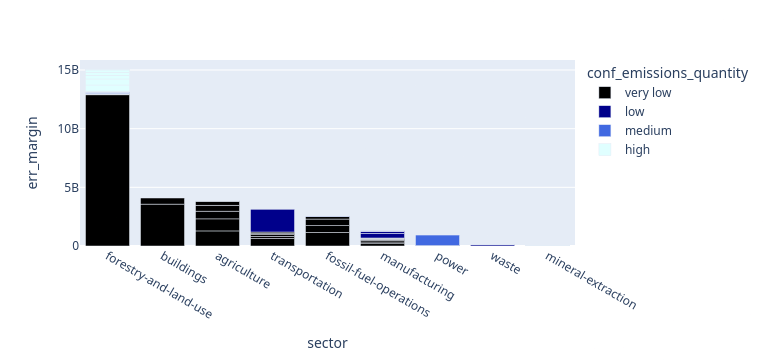

In [14]:
sec_rankings = (
df
.group_by(c_sector, c_subsector, c_gas_conf)
.agg(c_emissions_quantity.abs().sum(), C(ERR_MARGIN).abs().sum())
.sort(by=ERR_MARGIN, descending=True)  
)
# Building a nice ordre for the graph
_order = (sec_rankings
                 .group_by(c_sector)
                 .agg(C(ERR_MARGIN).sum())
                 .sort(by=ERR_MARGIN, descending=True)[SECTOR].to_list())

px.bar(sec_rankings,
      x=SECTOR,
       y=ERR_MARGIN,
       color=gas_conf,
       category_orders = {SECTOR: _order},
       log_y=False,
       hover_name=SUBSECTOR,
        color_discrete_map={'very low':'black','low': 'darkblue', 'medium': 'royalblue', 'high': 'lightcyan'}
)

What could we focus on? Here is a list in order of uncertainy. Better understanding house warming in China and the USA would make a significant difference, as well as road usage in the USA.

Also, focusing on the Chinese electrical power production (both for power generation and mining coal) is very important. Even if its margin of error is relatively low, this sector is so large that any improvement will have a disproportionate impact.

In [10]:
rankings = (df.group_by(c_iso3_country, c_subsector, c_sector)
 .agg(c_emissions_quantity.sum(), C(ERR_MARGIN).sum())
 .sort(by=ERR_MARGIN, descending=True)
 .with_row_index()
)
rankings.head(10)

shape: (10, 6)
┌───────┬──────────────┬────────────────────┬────────────────────┬────────────────────┬────────────┐
│ index ┆ iso3_country ┆ subsector          ┆ sector             ┆ emissions_quantity ┆ err_margin │
│ ---   ┆ ---          ┆ ---                ┆ ---                ┆ ---                ┆ ---        │
│ u32   ┆ enum         ┆ enum               ┆ enum               ┆ f64                ┆ f64        │
╞═══════╪══════════════╪════════════════════╪════════════════════╪════════════════════╪════════════╡
│ 0     ┆ CHN          ┆ residential-onsite ┆ buildings          ┆ 2.3382e9           ┆ 7.0146e8   │
│       ┆              ┆ -fuel-usage        ┆                    ┆                    ┆            │
│ 1     ┆ USA          ┆ road-transportatio ┆ transportation     ┆ 3.5297e9           ┆ 6.2229e8   │
│       ┆              ┆ n                  ┆                    ┆                    ┆            │
│ 2     ┆ USA          ┆ residential-onsite ┆ buildings          ┆ 1.7643e9           ┆ 5.2929e8   │
│       ┆              ┆ -fuel-usage        ┆                    ┆                    ┆            │
│ 3     ┆ CHN          ┆ coal-mining        ┆ fossil-fuel-operat ┆ 1.3067e9           ┆ 3.9200e8   │
│       ┆              ┆                    ┆ ions               ┆                    ┆            │
│ 4     ┆ CHN          ┆ electricity-genera ┆ power              ┆ 5.0054e9           ┆ 3.5528e8   │
│       ┆              ┆ tion               ┆                    ┆                    ┆            │
│ 5     ┆ CHN          ┆ iron-and-steel     ┆ manufacturing      ┆ 1.7387e9           ┆ 2.8236e8   │
│ 6     ┆ CHN          ┆ road-transportatio ┆ transportation     ┆ 1.5691e9           ┆ 2.7792e8   │
│       ┆              ┆ n                  ┆                    ┆                    ┆            │
│ 7     ┆ IND          ┆ residential-onsite ┆ buildings          ┆ 8.4234e8           ┆ 2.5270e8   │
│       ┆              ┆ -fuel-usage        ┆                    ┆                    ┆            │
│ 8     ┆ BRA          ┆ enteric-fermentati ┆ agriculture        ┆ 7.7923e8           ┆ 2.3377e8   │
│       ┆              ┆ on-cattle-pa…      ┆                    ┆                    ┆            │
│ 9     ┆ CHN          ┆ cropland-fires     ┆ agriculture        ┆ 7.3300e8           ┆ 2.1990e8   │
└───────┴──────────────┴────────────────────┴────────────────────┴────────────────────┴────────────┘

Grouping by country, we have have a discussion about which sectors are the most uncertain.

In the US, road transportation is a surprising source of uncertainty that should be relatively easy to address.

In [11]:
_plot_data = (rankings
        .filter(~(c_sector == FORESTRY_AND_LAND_USE)))
_country_order = (_plot_data
                 .group_by(c_iso3_country)
                 .agg(C(ERR_MARGIN).sum())
                 .sort(by=ERR_MARGIN, descending=True)[ISO3_COUNTRY].to_list())
px.bar(_plot_data.filter(c_iso3_country.is_in(_country_order[:10])), x=ISO3_COUNTRY,
       y=ERR_MARGIN, 
       color=SECTOR,
       hover_name=SUBSECTOR, 
       category_orders = {ISO3_COUNTRY: _country_order},
       log_y=False)

## Conclusion

We saw in this notebook how to define levels of uncertainty from qualitative assessments. This gives us areas of focus: electrical generation in China, transportation in the US, ...

It also underlines - again - the complexity around forestry and land uses. Vegetation is both the largest sink of carbon at scale and the least understood. There is much to understand in that area.